#1D CNN with spectrograms
In this trial we decided to create a 1D CNN with 2 convolutional layers. The network can take both MFCCs and melspectrogram as input.
The results showed are computed with kernel=3 and with MFCC transormation. To get the other results decomment the read_as_melspectrogram function, comment the read_as_mfccs one, choose the right input size and change the kernel size.

In [ ]:
import numpy as np 
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook; tqdm.pandas()
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import csv
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import keras
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Flatten, MaxPooling1D, Dense,
                          Dropout, Conv1D)
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
We define two function to calculate the Melspectrogram and the MFCCs for the further processing.

In [ ]:
def read_as_mfccs(path):
    '''
    Convert audio into a mfcc
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    
    return librosa.power_to_db(mfccs)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return librosa.power_to_db(melspectrogram)

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows()):
        x = read_as_mfccs(row.path)
        #x = read_as_melspectrogram(row.path) #decomment and comment the previous row to use melspectrogram 
        X.append(x.transpose())
    return X

---
Open the csv and create the train, validation and test sets.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DB/splitted_total12.csv")
path = df["path"].values
labels = df["label"].values

# Preprocess dataset and create validation sets
X1 = np.array(convert_wav_to_image(df))

train_paths, test_paths, train_labels, test_labels = train_test_split(X1, labels, test_size=0.2, random_state=123)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=123)

1235it [07:06,  2.90it/s]


---
Here we create the network

In [ ]:
input_shape=(1034,20)
#input_shape=(1034,128) #decomment and comment the previous row to use melspectrogram
model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1032, 64)          3904      
                                                                 
 conv1d_1 (Conv1D)           (None, 1030, 64)          12352     
                                                                 
 dropout (Dropout)           (None, 1030, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 515, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32960)             0         
                                                                 
 dense (Dense)               (None, 100)               3296100   
                                                        

---
We define the early stopping mechanism, the batch size and the number of epochs. Then, we fit the model.

In [ ]:
learning_rate = 0.00001
optimizer = optimizers.Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

batch_size=80
epochs = 100
history = model.fit(train_paths, train_labels, epochs=epochs, batch_size = batch_size,
                    validation_data=(val_paths, val_labels), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 8s 552ms/step - loss: 6.9296 - accuracy: 0.5757 - val_loss: 1.8056 - val_accuracy: 0.7248
Epoch 2/100
11/11 [==============================] - 4s 393ms/step - loss: 3.8555 - accuracy: 0.7187 - val_loss: 1.6383 - val_accuracy: 0.7852
Epoch 3/100
11/11 [==============================] - 6s 532ms/step - loss: 3.1702 - accuracy: 0.7950 - val_loss: 1.8334 - val_accuracy: 0.7919
Epoch 4/100
11/11 [==============================] - 5s 444ms/step - loss: 2.7707 - accuracy: 0.8236 - val_loss: 1.2869 - val_accuracy: 0.8725
Epoch 5/100
11/11 [==============================] - 4s 388ms/step - loss: 2.2113 - accuracy: 0.8451 - val_loss: 1.1507 - val_accuracy: 0.8859
Epoch 6/100
11/11 [==============================] - 6s 555ms/step - loss: 2.1184 - accuracy: 0.8582 - val_loss: 1.1696 - val_accuracy: 0.8725
Epoch 7/100
11/11 [==============================] - 5s 423ms/step - loss: 1.6779 - accuracy: 0.8605 - val_loss: 0.9164 - val_accuracy: 0.9060

---
Plotting the loss function and the accuracy for both train and validation set.

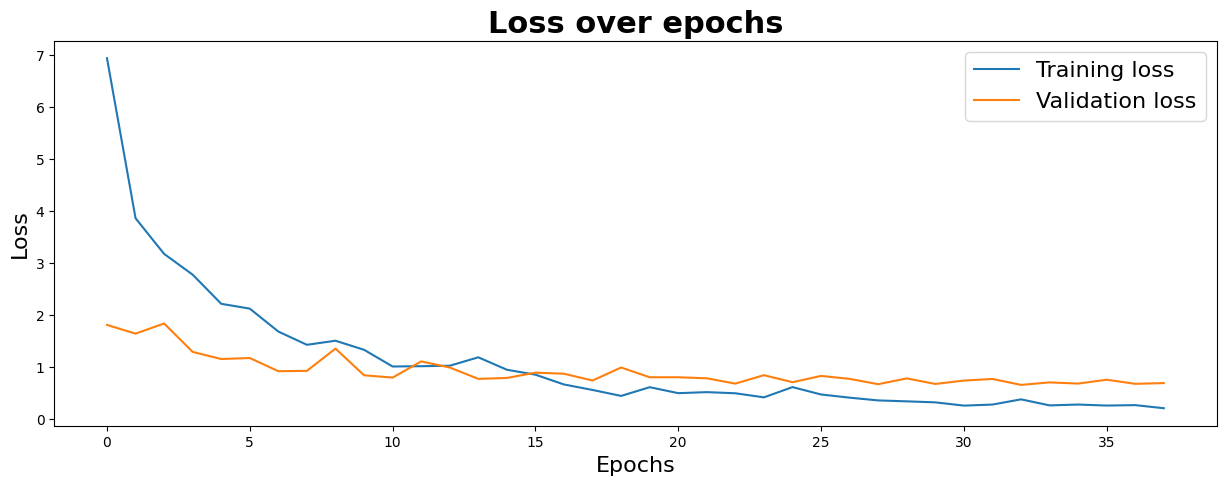

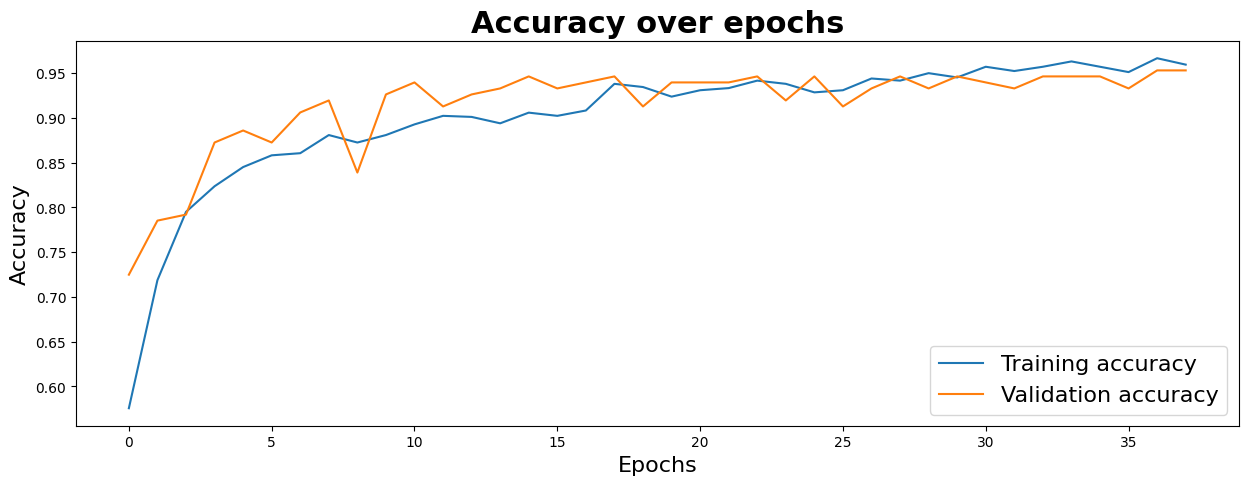

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_executed = early_stopping.stopped_epoch + 1
if epochs_executed != 1:
    rg = epochs_executed
else:
    rg = epochs    
plt.figure(figsize=(15,5))
plt.plot(range(rg), loss)
plt.plot(range(rg), val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.plot(range(rg), acc)
plt.plot(range(rg), val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

---
Evaluating the model on the test set, calculating the confusion matrix, the f1-score, the recall and the accuracy

8/8 [==============================] - 1s 62ms/step


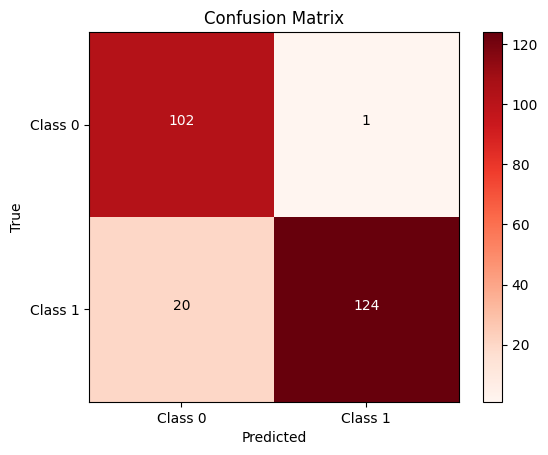

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       103
           1       0.99      0.86      0.92       144

    accuracy                           0.91       247
   macro avg       0.91      0.93      0.91       247
weighted avg       0.93      0.91      0.92       247



In [ ]:
test_loss, test_accuracy = model.evaluate(test_paths, test_labels)

predictions = model.predict(test_paths)

# Convert the predicted probabilities to class labels (0 or 1 in this case)
y_pred = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
# Add text annotations within each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

#Printing the accuracy, the f1-score and the recall for each class
predicted_probabilities = predictions.flatten()
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

report = classification_report(test_labels, predicted_labels)
print(report)

In [ ]:
model.save('/content/drive/MyDrive/models/1-D CNN for MFCCs')